In [4]:
import pandas as pd

# Load your dataset
df = pd.read_csv("ai_ghibli_trend_dataset_v2.csv")

In [5]:
# Feature Engineering
from sklearn.preprocessing import MinMaxScaler

# Create a combined engagement score
df["engagement_score"] = df["likes"] + df["shares"] + df["comments"]

# Normalize for plotting if needed
scaler = MinMaxScaler()
df["engagement_normalized"] = scaler.fit_transform(df[["engagement_score"]])

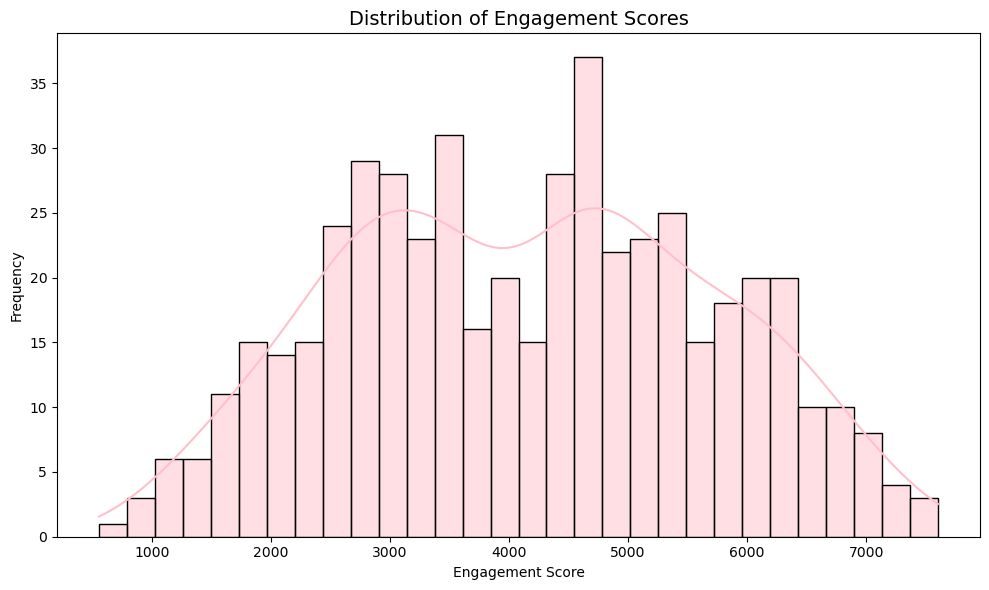

In [6]:
# Plot: Engagement Score Distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df["engagement_score"], bins=30, kde=True, color="pink")
plt.title("Distribution of Engagement Scores", fontsize=14)
plt.xlabel("Engagement Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

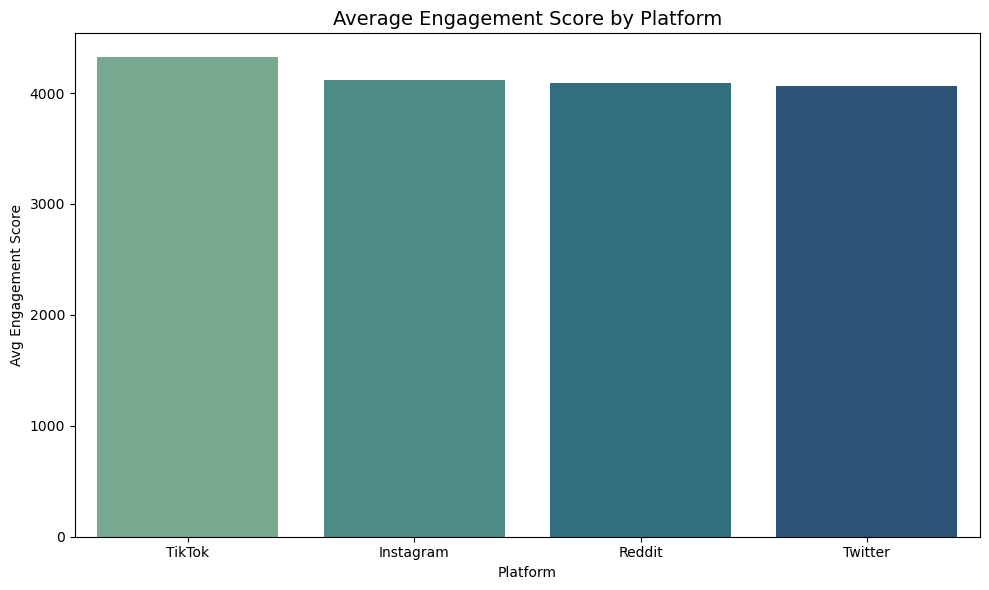

In [7]:
# Plot: Average Engagement by Platform
plt.figure(figsize=(10, 6))
platform_avg = df.groupby("platform")["engagement_score"].mean().sort_values(ascending=False)
sns.barplot(x=platform_avg.index, y=platform_avg.values, palette="crest")
plt.title("Average Engagement Score by Platform", fontsize=14)
plt.xlabel("Platform")
plt.ylabel("Avg Engagement Score")
plt.tight_layout()
plt.show()

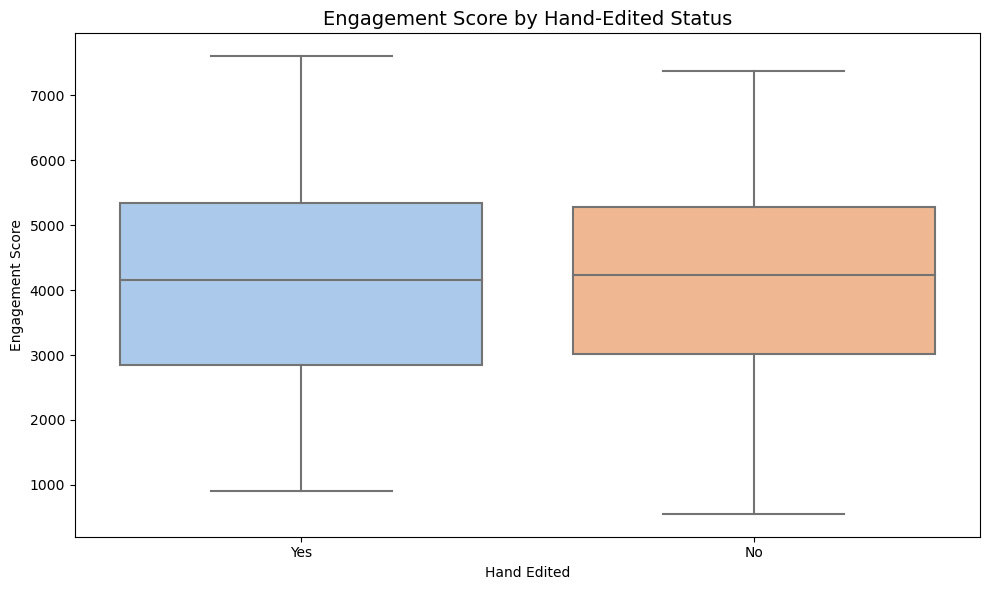

In [8]:
# Plot: Hand-Edited vs Non-Edited
plt.figure(figsize=(10, 6))
sns.boxplot(x="is_hand_edited", y="engagement_score", data=df, palette="pastel")
plt.title("Engagement Score by Hand-Edited Status", fontsize=14)
plt.xlabel("Hand Edited")
plt.ylabel("Engagement Score")
plt.tight_layout()
plt.show()

In [9]:
!pip install wordcloud

     -------------------------------------- 300.4/300.4 kB 4.7 MB/s eta 0:00:00


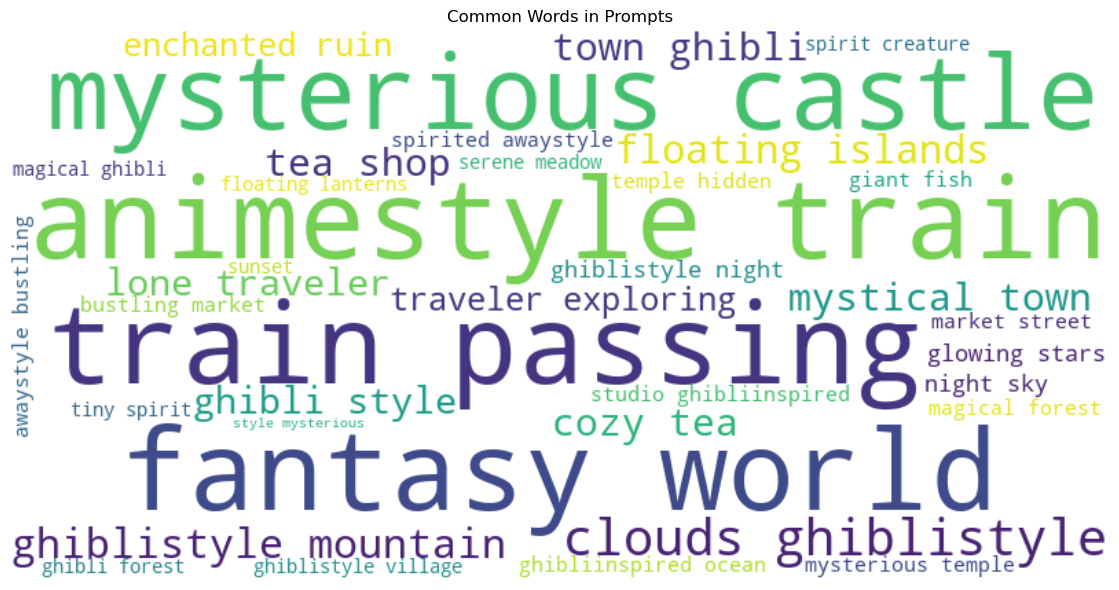

In [13]:
# Plot: Prompt Word Cloud
from wordcloud import WordCloud
import re

# Combine all prompts into one string
all_prompts = " ".join(df["prompt"].tolist()).lower()
all_prompts = re.sub(r"[^a-zA-Z\s]", "", all_prompts)  # clean punctuation

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_prompts)

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Common Words in Prompts")
plt.tight_layout()
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.



📊 Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.96      0.82        72
           1       0.25      0.04      0.06        28

    accuracy                           0.70       100
   macro avg       0.48      0.50      0.44       100
weighted avg       0.59      0.70      0.61       100


🧠 Top Keywords by Topic:
Topic #1: style, cozy, town, shop, tea, mystical, meadow, serene, spirit, creature
Topic #2: islands, mountain, floating, ghiblistyle, magical, forest, ghibli, sunset, village, castle
Topic #3: stars, glowing, night, sky, traveler, enchanted, exploring, lone, ruin, fish
Topic #4: mysterious, castle, clouds, temple, hidden, ghiblistyle, bustling, awaystyle, market, street
Topic #5: world, passing, fantasy, animestyle, train, village, sunset, lanterns, magical, forest


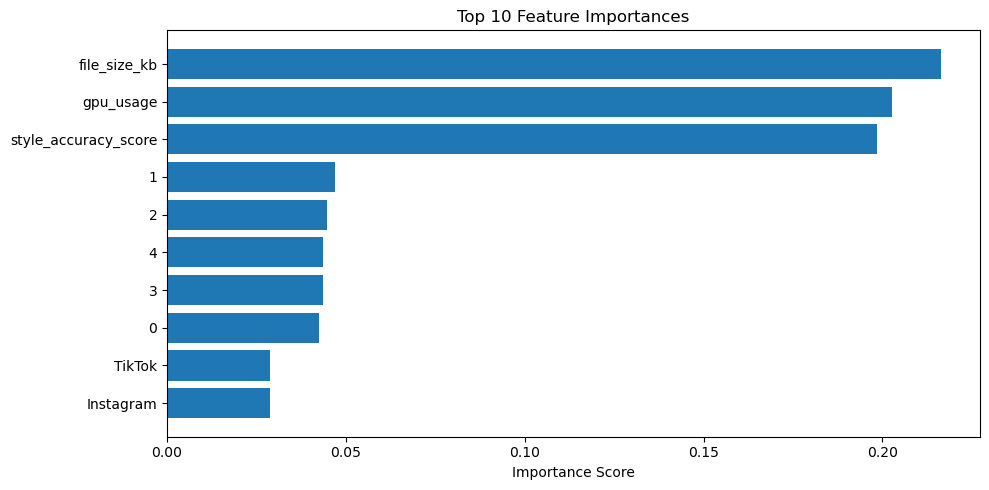

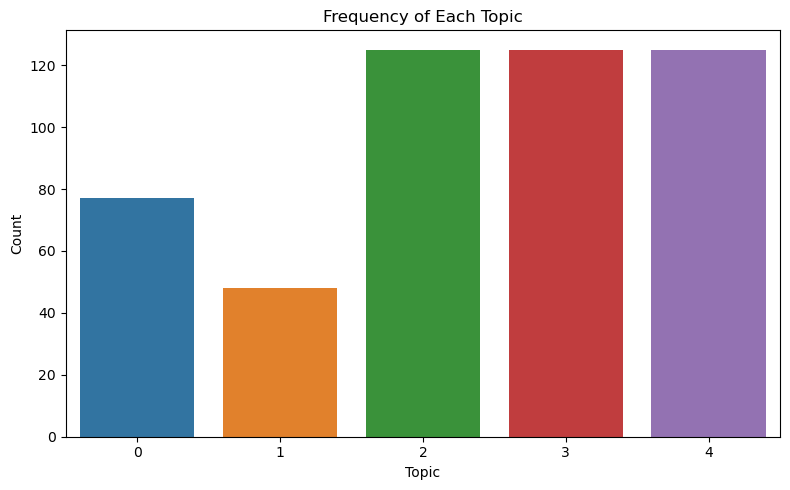

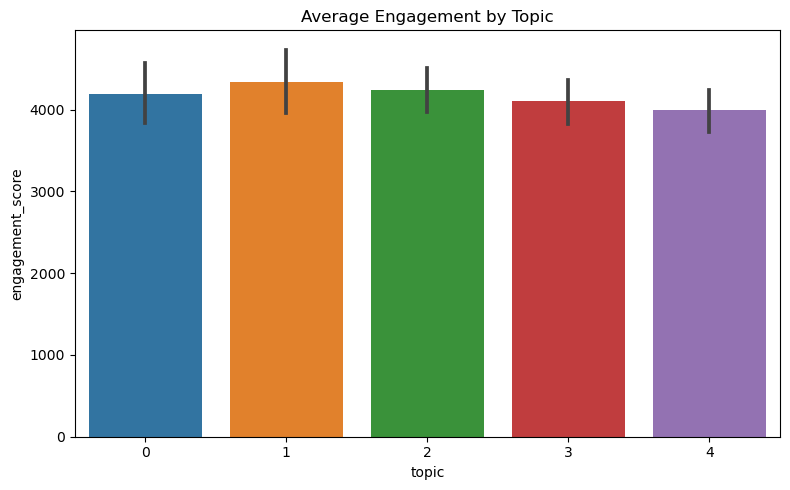

In [15]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load dataset
df = pd.read_csv("ai_ghibli_trend_dataset_v2.csv")

# Download NLTK stopwords
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Prompt cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    return " ".join([word for word in text.split() if word not in stop_words])

df["clean_prompt"] = df["prompt"].apply(clean_text)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=500)
tfidf_matrix = vectorizer.fit_transform(df["clean_prompt"])

# LDA topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda.fit_transform(tfidf_matrix)

df["topic"] = np.argmax(lda_topics, axis=1)
df["engagement_score"] = df["likes"] + df["shares"] + df["comments"]
threshold = df["engagement_score"].quantile(0.75)
df["high_engagement"] = (df["engagement_score"] >= threshold).astype(int)

# Classifier features
X = pd.concat([
    pd.DataFrame(lda_topics),
    df[["style_accuracy_score", "gpu_usage", "file_size_kb"]],
    pd.get_dummies(df["platform"]),
    pd.get_dummies(df["is_hand_edited"])
], axis=1)
X.columns = X.columns.astype(str)
y = df["high_engagement"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred))

# Topic keywords
feature_names = vectorizer.get_feature_names_out()
print("\n🧠 Top Keywords by Topic:")
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

# 🔥 Feature Importance Plot
importances = clf.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10
plt.figure(figsize=(10, 5))
plt.title("Top 10 Feature Importances")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()

# 📊 Topic Frequency Plot
plt.figure(figsize=(8, 5))
sns.countplot(x=df["topic"])
plt.title("Frequency of Each Topic")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("topic_frequency.png")
plt.show()

# 📈 Engagement per Topic
plt.figure(figsize=(8, 5))
sns.barplot(x="topic", y="engagement_score", data=df)
plt.title("Average Engagement by Topic")
plt.tight_layout()
plt.savefig("engagement_by_topic.png")
plt.show()

In [20]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt

st.title("AI-Generated Ghibli Trend Analysis")

st.markdown("### Engagement vs Topic")
img = plt.imread("engagement_by_topic.png")
st.image(img)

st.markdown("### Topic Frequency")
img2 = plt.imread("topic_frequency.png")
st.image(img2)

st.markdown("### Feature Importance")
img3 = plt.imread("feature_importance.png")
st.image(img3)

ModuleNotFoundError: No module named 'streamlit'

In [66]:
#streamlit run app.py

In [16]:
# Purpose: Discover the themes people are prompting most often in Ghibli-style image generation — 
# this tells you what kinds of story concepts users are imagining.
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load dataset
df = pd.read_csv("ai_ghibli_trend_dataset_v2.csv")

# Clean prompts
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    return " ".join([word for word in text.split() if word not in stop_words])
df["clean_prompt"] = df["prompt"].apply(clean_text)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=500)
tfidf_matrix = vectorizer.fit_transform(df["clean_prompt"])

# LDA Clustering (Topic Modeling)
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda.fit_transform(tfidf_matrix)
df["topic"] = np.argmax(lda_topics, axis=1)

# Engagement score
df["engagement_score"] = df["likes"] + df["shares"] + df["comments"]

# Classifier target (top 25% is high engagement)
threshold = df["engagement_score"].quantile(0.75)
df["high_engagement"] = (df["engagement_score"] >= threshold).astype(int)

# Prepare features
X = pd.concat([
    pd.DataFrame(lda_topics),
    df[["style_accuracy_score", "gpu_usage", "file_size_kb"]],
    pd.get_dummies(df["platform"]),
    pd.get_dummies(df["is_hand_edited"])
], axis=1)
X.columns = X.columns.astype(str)
y = df["high_engagement"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Show top keywords per topic
feature_names = vectorizer.get_feature_names_out()
print("\nTop Keywords by Topic:")
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.96      0.82        72
           1       0.25      0.04      0.06        28

    accuracy                           0.70       100
   macro avg       0.48      0.50      0.44       100
weighted avg       0.59      0.70      0.61       100


Top Keywords by Topic:
Topic #1: style, cozy, town, shop, tea, mystical, meadow, serene, spirit, creature
Topic #2: islands, mountain, floating, ghiblistyle, magical, forest, ghibli, sunset, village, castle
Topic #3: stars, glowing, night, sky, traveler, enchanted, exploring, lone, ruin, fish
Topic #4: mysterious, castle, clouds, temple, hidden, ghiblistyle, bustling, awaystyle, market, street
Topic #5: world, passing, fantasy, animestyle, train, village, sunset, lanterns, magical, forest


Training Accuracy: 0.7514285714285714
Test Accuracy: 0.74


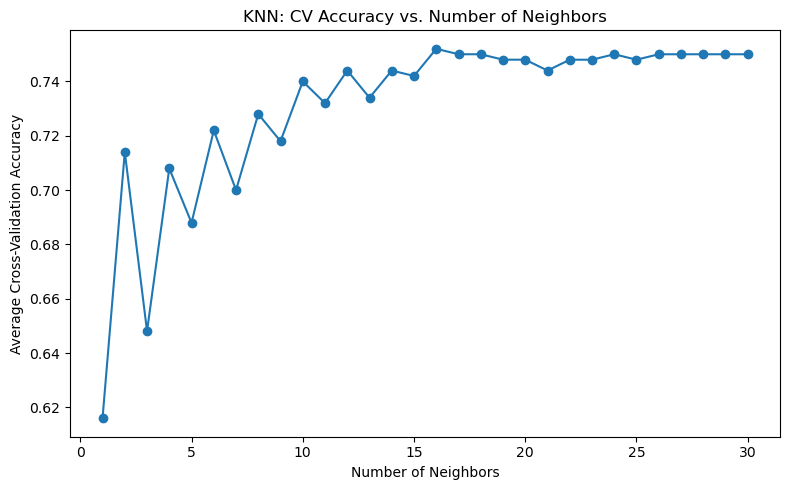

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Scale features for KNN (KNN is sensitive to feature scales)
scaler_knn = StandardScaler()
X_scaled_knn = scaler_knn.fit_transform(X)

# Create training and test sets using stratification to preserve class balance
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(
    X_scaled_knn, y, test_size=0.3, random_state=42, stratify=y
)

# Initialize and fit the KNN classifier with 15 neighbors
knn_model = KNeighborsClassifier(n_neighbors=15, weights='uniform', p=2)
knn_model.fit(X_train_knn, y_train_knn)

# Evaluate on the training set
train_acc = accuracy_score(y_train_knn, knn_model.predict(X_train_knn))
print("Training Accuracy:", train_acc)

# Evaluate on the test set
test_acc = accuracy_score(y_test_knn, knn_model.predict(X_test_knn))
print("Test Accuracy:", test_acc)

# --- Cross-Validation: Accuracy vs. Number of Neighbors ---
def cv_accuracy_score(X, y, k):
    """
    Trains a KNN model with k neighbors using 3-fold stratified cross-validation
    and returns the average accuracy.
    """
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    accuracies = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    for train_idx, holdout_idx in skf.split(X, y):
        X_train_cv, X_holdout_cv = X[train_idx], X[holdout_idx]
        # Note: y is a pandas Series so we use .iloc for indexing
        y_train_cv, y_holdout_cv = y.iloc[train_idx], y.iloc[holdout_idx]
        knn.fit(X_train_cv, y_train_cv)
        acc = accuracy_score(y_holdout_cv, knn.predict(X_holdout_cv))
        accuracies.append(acc)
    return np.mean(accuracies)

# Explore how accuracy changes over a range of k values
neighbors_range = range(1, 31)
cv_scores = [cv_accuracy_score(X_scaled_knn, y, k) for k in neighbors_range]

plt.figure(figsize=(8, 5))
plt.plot(neighbors_range, cv_scores, marker='o')
plt.xlabel("Number of Neighbors")
plt.ylabel("Average Cross-Validation Accuracy")
plt.title("KNN: CV Accuracy vs. Number of Neighbors")
plt.tight_layout()
plt.show()


In [30]:
from sklearn.metrics import accuracy_score

# Determine the majority class from the training data
majority_class = y_train_knn.mode()[0]

# Create baseline predictions for the test set by assigning the majority class to all instances
baseline_predictions = np.full(shape=y_test_knn.shape, fill_value=majority_class)

# Compute baseline accuracy
baseline_accuracy = accuracy_score(y_test_knn, baseline_predictions)
print("Baseline Accuracy (majority class):", baseline_accuracy)

# Compare with the KNN model test accuracy (test_acc computed earlier)
print("KNN Test Accuracy:", test_acc)

# Check if the KNN model is performing better than the baseline
if test_acc > baseline_accuracy:
    print("The KNN model performs better than the baseline prediction.")
else:
    print("The KNN model does not perform better than the baseline prediction.")


Baseline Accuracy (majority class): 0.7533333333333333
KNN Test Accuracy: 0.74
The KNN model does not perform better than the baseline prediction.


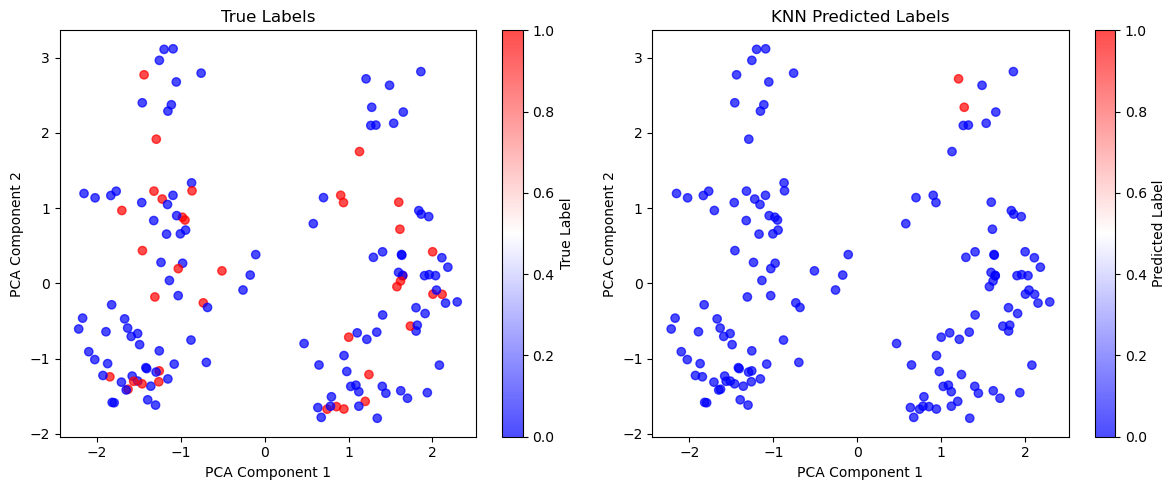

In [19]:
from sklearn.decomposition import PCA

# Obtain predictions for the test set
knn_predictions = knn_model.predict(X_test_knn)

# Reduce the test set dimensionality to 2D for visualization
pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test_knn)

# Create side-by-side scatter plots for comparison
plt.figure(figsize=(12, 5))

# Plot 1: True Labels
plt.subplot(1, 2, 1)
scatter_true = plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test_knn, cmap='bwr', alpha=0.7)
plt.title("True Labels")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter_true, label='True Label')

# Plot 2: KNN Predicted Labels
plt.subplot(1, 2, 2)
scatter_pred = plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=knn_predictions, cmap='bwr', alpha=0.7)
plt.title("KNN Predicted Labels")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter_pred, label='Predicted Label')

plt.tight_layout()
plt.show()


In [ ]:
Model 1: Latent Dirichlet Allocation (LDA) — Clustering Prompts into Topics
- What It Does:
Groups all user prompts into themes or topics based on the words they use.
Helps identify what kind of stories people are imagining when they generate Ghibli-style art.

- What the Code Does:
1) Cleans the prompt text (removes stopwords and punctuation).
2) Converts prompts into a numeric format using TF-IDF.
3) Applies LDA to find 5 common clusters (or topics).
4) Assigns each prompt to one topic.

- What the Output Means (from your result):
Example output:
Topic #1 might represent prompts about small cozy villages or shops (slice-of-life Ghibli vibes).
Topic #2 is about magical floating landscapes and scenic beauty.

- Why It’s Useful:
This shows what kinds of Ghibli-style content people want to see — a form of crowdsourced demand for new movie themes.

In [ ]:
Model 2: Random Forest Classifier — Predicting Engagement
- What It Does:
Predicts whether a prompt will lead to high engagement (likes, shares, comments).
Helps figure out what features make an image go viral.

- What the Code Does:
1) Adds a column for “high engagement” (top 25% of posts).
2) Uses features like:
Thematic topic (from LDA),Style accuracy,Platform (Instagram/TikTok/etc.),Whether it was hand-edited.
3) Trains a Random Forest model to predict whether a new prompt will be popular.
4) Outputs model performance (classification report).

- What the Output Means (from your result):
The model isn’t perfect — it struggles to predict viral prompts.
But it shows which features matter most (like prompt topic, platform, editing).

- Why It’s Useful:
Studios can use this to forecast demand — which themes or types of AI content are likely to succeed, so they invest in the right ideas.

In [2]:
Model 3: K-Nearest Neighbors Classifier - Predicting Virality
- What It Does:
    

SyntaxError: invalid syntax (1016034783.py, line 1)